# Carls' Implementation of QAOA using PytKet and COBAYLA

## Background

### QAOA and VQE Overview

QAOA is a specific example of Variational Quantum Eigensolver (VQE).  All VQEs aim to find the ground state of a Hamiltonion, which can then be used for tasks such as optimization.  

These systems function as a feedback loop between a classical and quantum system.  Our classical system is a form of function optimization algorithm (Think Gradient Descent) while our quantum system implements our problem statement. In a VQE (and by extension, in a QAOA), we treat a quantum system as the function which we wish to minimze with the classical optimization algorithm.  

### Designing the Quantum System

Our goal for the quantum system is to find the ground state of some target Hamiltonion.  We do this by employing the Adiabatic theorem.  This theorem states that if we originate in the ground state of some Hamiltonion, then transition slowly enough (i.e. over enough time steps) to eventually reach our target state, we will now be in the ground state of our target Hamiltonion.

To find the ground state of our target Hamiltonion, we first start in a system with a known ground state.  This is generally the result of a n dimensional Hadamard $H^{\otimes n}$.  We then apply an alternating series of parametric 'Problem' and parametric 'Mixing' Circuits.  The problem circuits encode the target Hamiltonion while the mixing circuit are used to introduce rotations in a different orientation to the problem circuits.  Each repetition is parametarized by its own parameter, denoted $\gamma_i$ and $\beta_i$ for problem circuit $i$ and mixing circuit $i$.  In total, this series is paramaterized by a length $p$ vector $\gamma = (\gamma_1, \gamma_2, ... \gamma_p)$ and length $p$ vector $\beta = (\beta_1, \beta_2, ..., \beta_p)$.  This decomposition of our target Hamiltonion into an alternating sequence of operators is known as Totterization.

### Integrating Quantum and Classical

At each iteration $i$ of our classical solver, we instantiate a new instance of our quantum system.  We then calculate the expectation value of our target Hamiltonion using our state vector.  Note that we must run a number of shots on the quantum system before we can get an good estimate for the expecation value.

At this point, we pass the expectation value into our classical solver, which then updates $\beta$ and $\gamma$.  This repeats until a stopping criteria for the classical solver (set by the user) is met. 

## Our Project

We implement a QAOA solver in Qiskit and integrate it with Quantinuum's pytket.  Furthermore, we integrate our quantum program with the COBYLA classical optimization algorithm.  

Our original goal was to extend our QAOA system to solve the Traveling Salesman Problem.  This would enable us to iterface our QAOA with our custom designed search and rescue app.  This would demonstrate the possiblity for search and rescue teams to leverage quantum computation in order to more efficently plan their serach missions. As can be seen in our writeup, `QUBO_Traveling_Salesman_Overview`, we were able to create a cost function for Traveling Salesman and had the theoretical means to convert it to an appropriate Quantum Circuit.  However, we were unable to implement this as a Quantum Circuit and connect it to our graphical interface.  

### References

https://qiskit.org/textbook/ch-applications/qaoa.html

Please refer to the references in QUBO overview writeup for additional information.

In [6]:
#!pip3 install qiskit
#!pip3 install pytket-qiskit
#!pip3 install pytket
!pip3 install networkx

import networkx as nx
import matplotlib.pyplot as plt
import pytket

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
from pytket.extensions.quantinuum import QuantinuumBackend
from pytket.extensions.qiskit import qiskit_to_tk
from pytket.circuit.display import render_circuit_jupyter

ModuleNotFoundError: No module named 'networkx'

## Connecting with Quantinuum H1-2E Machine

We create a connection with Quantinuum backend machine.

In [5]:
machine = 'H1-2E'
backend = QuantinuumBackend(device_name=machine)
backend.login()
print(machine, "status: ", backend.device_state(device_name=machine))

Enter your Quantinuum email:  elchun@mit.edu
Enter your Quantinuum password:  ········


H1-2E status:  online


## Create QUBO Instance

We first create an instance of a Quadratic Unconstrained Binary Optimization problem.

In this example, we solve the Max-Cut problem.  The user will be prompted to instantiate a graph of their choosing

In [7]:
enable_user_graph_input = True 

In [8]:
def get_user_graph():
    """
    Generates graph by prompting user for number 
    of nodes and edge pairs.
    
    Returns: Graph, number of nodes
    """
    G = nx.Graph()
    n_nodes = int(input('Enter number of nodes: '))
    print('Now add edges.  Enter "done" to finish.')
    nodes_list = list(range(n_nodes))
    edges_list = []
    while True:
        nodes = input('Enter pair of nodes for edge "u, v": ')
        if nodes == 'exit':
            break
        u, v = nodes.split(',')
        edges_list.append((int(u), int(v)))
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    print(edges_list)
    return G, n_nodes

In [9]:
p = 1
shots = 1000

if enable_user_graph_input:
    G, n_qubits = get_user_graph()
else:
    n_qubits = 6
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3,4,5])
    # G.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)])
    G.add_edges_from([(0, 1), (1, 2), (1, 3), (3, 4), (4,5), (4,6)])
    
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

NameError: name 'nx' is not defined

## Convert to Quantum Circuit

We now convert our graph into an appropriate quantum circuit to run QAOA.  This involves creating the mixing circuit (A set of $X$ rotations in our case), problem circuit (Implemented using $ZZ$ rotations corresponding to each edge in our graph), and the initial state setup circuit ($H^{\otimes n}$).  We then combine these circuits into a complete QAOA quantum circuit.

### Create Mixing Quantum Circuit

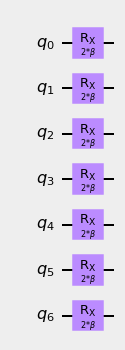

In [8]:
def create_mixing_qc(n_qubits, beta):
    """
    Create mixing quantum circuit.
    
    Return a quantum circuit instance.
    """
    qc_mix = QuantumCircuit(n_qubits)
    for i in range(0, n_qubits):
        qc_mix.rx(2 * beta, i)
    return qc_mix

qc = create_mixing_qc(n_qubits, Parameter("$\\beta$"))

circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})

        

### Create Problem Quantum Circuit

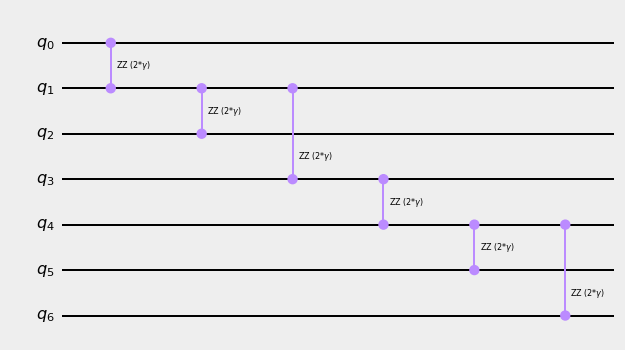

In [9]:
def create_graph_problem_qc(G, n_qubits, gamma):
    """
    Create problem quantum circuit.
    
    Return a quantum circuit instance.
    """
    qc_p = QuantumCircuit(n_qubits)
    for pair in list(G.edges()):  # pairs of nodes
        qc_p.rzz(2 * gamma, pair[0], pair[1])
        # qc_p.barrier()
    return qc_p

qc = create_graph_problem_qc(G, n_qubits, Parameter("$\\gamma$"))
circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Create Initial State

In [10]:
def create_initial_qc(n_qubits):
    """
    Create initial quantum circuit.  This is a set of n hadamards.
    
    Return a quantum circuit instance.
    """
    
    qc_0 = QuantumCircuit(n_qubits)
    for i in range(0, n_qubits):
        qc_0.h(i)
    return qc_0

qc = create_initial_qc(n_qubits)
circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})         

NameError: name 'QuantumCircuit' is not defined

### Combine into QAOA Circuit

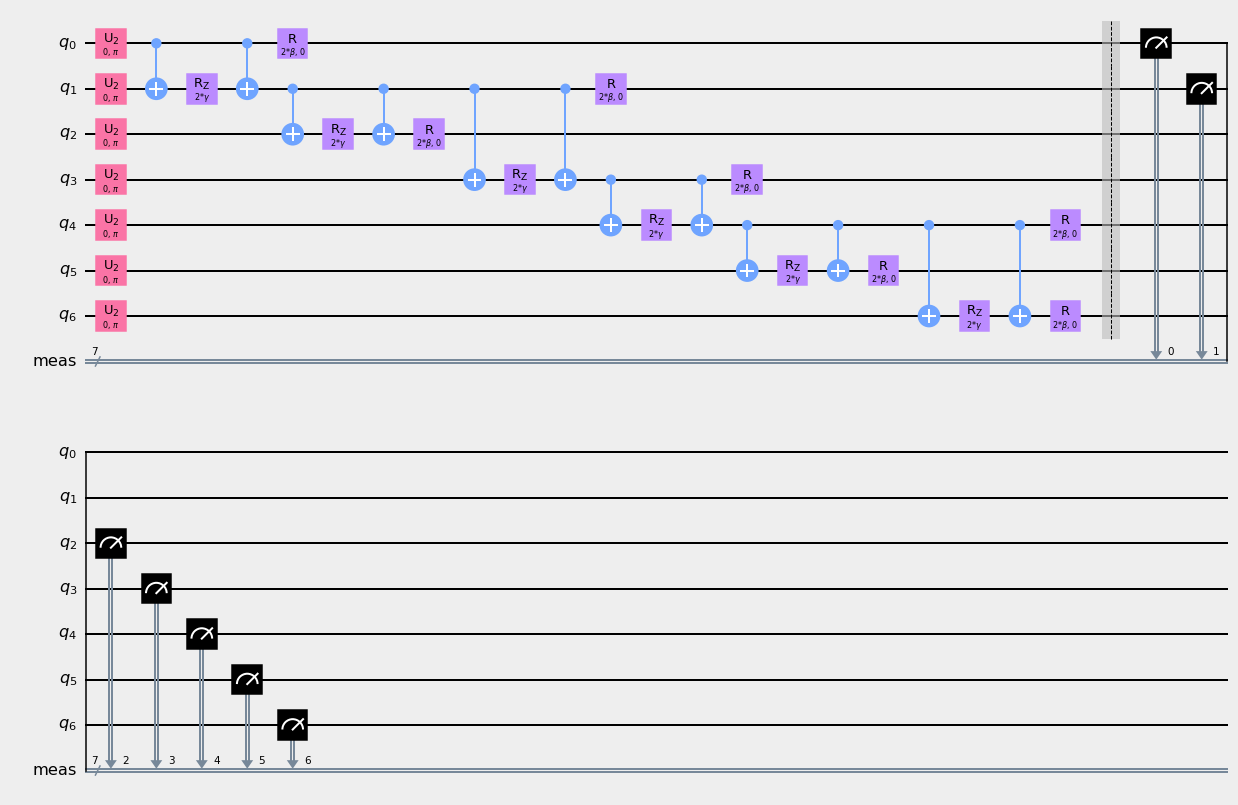

In [11]:
def create_qaoa_circ(n_qubits, problem_qc_generator, mixing_qc_generator, 
                     beta_list, gamma_list):
    """
    n_qubits: number of qubits to use
    problem_qc_generator: function to generate problem quantum circuit.  Must take
        n_qubits, gamma_list.
    mixing_qc_generator: function to generate mixing quantum circuit.  Must take
        n_qubits, beta_list.
    beta_list: List of betas to use for trial where beta[i] is used in the ith iteration of 
        Trotterization.
    gamma_list: List of gammas to use for trial which gamma[i] is used in the ith iteration of 
        Trotterization.
    
    """
    qc = QuantumCircuit(n_qubits)
    
    # Add initial state and specify which qubits to attach
    attach_qubits = [i for i in range(0, n_qubits)]
    qc.append(create_initial_qc(n_qubits), attach_qubits[:])
    
    assert len(beta_list) == len(gamma_list), 'Beta and gamma list must \
        be the same length'
    n_reps = len(beta_list)
    
    # Now add repeated applications of problem and mixing circuits
    for rep in range(0, n_reps):
        qc.append(problem_qc_generator(n_qubits, gamma_list[rep]), attach_qubits[:])
        qc.append(mixing_qc_generator(n_qubits, beta_list[rep]), attach_qubits[:])
    
    qc.measure_all()
    return qc

beta = Parameter("$\\beta$")
gamma = Parameter("$\\gamma$")
beta_list = [beta for _ in range(p)]
gamma_list = [gamma for _ in range(p)]

# Define wrappers for problem qc and mixing qc generator.
# This allows us to solve a variety of QUBO problems with the same stack.
def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)


qc = create_qaoa_circ(n_qubits, graph_qc_generator, mixing_qc_generator,
                      beta_list, gamma_list)

# Decompose to show individual elements, then draw
circuit_drawer(qc.decompose().decompose(), output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Create helper method to calculate expection

We must calculate the expectation value of our transformed Hamiltonion.  This is easily done with a helper function.

Codewise, this is implemented using the generator `get_expectation` which returns a function `execute_circ(theat)` where theta is the concatenation of beta and gamma ($\theta = \beta \oplus \gamma$).  This function is what the optimizer will optimize.

We also utilize a function to convert the raw count into an expectation.

In [27]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation_tket(counts, G):
    """
    Compute the expecation value where counts is the
    return type of a tket call and G is a graph.
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

    
def get_expectation(problem_qc_generator, mixing_qc_generator, n_qubits, shots=1028):
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    # backend = Aer.get_backend('qasm_simulator')
    
    def execute_circ(theta):
        midpt = len(theta) // 2
        beta_list = theta[:midpt]
        gamma_list = theta[midpt:]
        
        qc = create_qaoa_circ(n_qubits, problem_qc_generator, mixing_qc_generator,
                          beta_list, gamma_list)
        
        tk_qc = qiskit_to_tk(qc)
        tk_qc.measure_all()
        # There are three levels of optimization (we set to 1 for now)
        compiled_qc = backend.get_compiled_circuit(tk_qc, optimisation_level=1)
        
        handle = backend.process_circuit(compiled_qc, n_shots=shots)
        print('handle: ', handle)
        status = backend.circuit_status(handle)
        print('status: \n', status)
        
        results = backend.get_result(handle)
        counts = results.get_counts()
        
        # # Have to decompose in order to run backend
        # counts = backend.run(qc.decompose().decompose(), seed_simulator=10, 
        #                      shots=shots).result().get_counts()

        return compute_expectation_tket(counts, G)
    
    return execute_circ

# Wrappers for problem generating function
def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

# Wrappers for mixing generating function
def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)

# This returns a function which can optimize classically
get_expectation(graph_qc_generator, mixing_qc_generator, n_qubits, shots)


<function __main__.get_expectation.<locals>.execute_circ(theta)>

### Define QAOA

In [28]:
def qaoa(problem_qc_generator, mixing_qc_generator, n_qubits, shots):
    """
    Run qaoa using the given problem_qc_generator, mixing_qc_generator, number of qubits, and shots.
    """
    
    expectation = get_expectation(problem_qc_generator, mixing_qc_generator, 
                                  n_qubits, shots)

    initial_theta_value = [1.0 for _ in range(p * 2)]
    res = minimize(expectation, 
                   initial_theta_value,
                   method='COBYLA',
                   tol=0.001) 
    
    return res
    
res = qaoa(graph_qc_generator, mixing_qc_generator, n_qubits, shots)
print(res)
print(res.x)  # [ 1.357e+00  1.125e+00]

handle:  ('30934e86242a44bc989ffce11d5e9287', 'null')
status: 
 CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "circuit-352", "submit-date": "2023-01-29T07:34:04.646716", "result-date": null, "queue-position": null, "cost": null, "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)
handle:  ('3e3deff47ab5421da71a435052918beb', 'null')
status: 
 CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "circuit-362", "submit-date": "2023-01-29T07:34:25.944925", "result-date": null, "queue-position": null, "cost": null, "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)
handle:  ('c915397aa1354150b5006d7785b0bb75', 'null')
status: 
 CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queue

### Run QAOA

In [ ]:
# sim_backend = Aer.get_backend('aer_simulator')
res_shots = shots

def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)

beta, gamma = res.x[:p], res.x[p:]

qc = create_qaoa_circ(n_qubits, graph_qc_generator, mixing_qc_generator,
                          beta, gamma)

tk_qc = qiskit_to_tk(qc)
tk_qc.measure_all()
compiled_qc = backend.get_compiled_circuit(tk_qc, optimisation_level=1)
handle = backend.process_circuit(compiled_qc, n_shots=res_shots)
status = backend.circuit_status(handle)
print('handle: ', handle)
print('status: \n', status)

results = backend.get_result(handle)
counts = results.get_counts()

# counts = sim_backend.run(qc.decompose().decompose(), seed_simulator=10, shots=10000).result().get_counts()


# Print out bitstring

def show_counts(counts):
    print(counts)
    values = list(counts.values())
    values.sort()
    viz = s[-2:]
    
    for k, v in counts.items():
    if v in viz:
        print(k[::-1])
    
    print(sum(s))
    
    
    

# print(counts)
# s = []
# max_val = 0
# for _ in counts.values():
#     s.append(_)

# s.sort()
# viz = s[-2:]
# for k, v in counts.items():
#     if v in viz:
#         print(k[::-1])

# print(sum(s))

show_counts(counts)

plot_histogram({str(k): v for k, v in counts.items()})